# Исследование данных о продажах, оценках, жанрах и платформах игр интернет-магазина

**Цель исследования** - выявить закономмерности, определяющие успешность игр, для определения потенциально популярного продукта и планирования будущих рекламных кампаний. 

**Ход исследования:** 

1. Загрузка данных - считать данные из CSV-файла games.csv. 
 
 
 
2. Предобработка данных:
    * корректировка формата названий столбцов, 
    * приведение к корректным типам данных, 
    * обработка пропусков,  
    * расчет суммарных продаж по регионам, 
    * проверка дубликатов.
 
 
 
3. Исследовательский анализ: 
    * анализ количества игр по годам, 
    * анализ продаж в разрезе платформ, распределение их по годам, 
    * определить актуальный период для построения прогноза на 2017 год (данные за предшествующие актуальному периоды не учитывать), 
    * анализ динамики продаж в разрезе платформ, определение потенциально прибыльных платформ, 
    * оценка влияния отзывов пользователей и критиков на продажи, построение диаграммы рассеивания для корреляции между отзывами и продажами, 
    * оценка распределения игр по жанрам, анализ прибыльности по жанрам. 
 
 
 
4. Формирование портрета пользователя для каждого региона: 
    * определение топ-5 популярных платформ, 
    * определение топ-5 популярных жанров, 
    * оценка влияния ESRB (ассоциация, определяющая возрастной рейтинг компьютерных игр) на продажи. 
 
 
 
5. Проверка гипотез: 
    * средние пользовательские рейтинги платформ Xbox One и PC одинаковые, 
    * средние пользовательские рейтинги жанров Action и Sports разные. 
 
 
 
6. Общий вывод - резюмирование результатов, формирование ключевых выводов, описание рекомендаций. 
 
 
 
**Описание данных:** 
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

***Импорты для проекта:***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns

***Функции:***

In [2]:
def get_primary_information(data):
    '''Получение общей первичной информации в читаемом виде о передаваемом DataFrame
    
    Принимаемые агрументы:
    data -- DataFrame, о котором необходимо получить общую первичную информацию'''
    
    # Возвращает медианное значение Series
    print('Общая информация:')
    data.info()
    print('10 первых и 10 последних строк:')
    print(data.head(10))
    print(data.tail(10))

In [3]:
def print_data_of_nan(data):
    '''Получение процентов и количества явных пропусков (NaN) в столбцах передаваемого DataFrame
    
    Принимаемые агрументы:
    data -- DataFrame, в котором необходимо получить информацию о пропусках'''

    # Рассчитываем процент пропусков в каждом столбце
    percent_missing = pd.DataFrame(data.isna().mean()).rename(columns={0: 'Процент пропусков в столбцах, %'})

    # Рассчитываем количество пропусков в каждом столбце
    count_missing = data.isna().sum().rename('Количество пропусков, шт.')

    # Объединяем оба столбца в один DataFrame, производим сортировку по убыванию процента пропусков
    result = pd.concat([percent_missing, count_missing], axis=1).sort_values(by='Процент пропусков в столбцах, %', ascending=False)

    # Применяем стили к полученному DataFrame с данными о пропусках
    result = result.style.format({'Процент пропусков в столбцах, %': '{:.2%}'}).background_gradient('coolwarm')

    # Выводим на экран полученную информацию
    display(result)

In [4]:
def get_rows_fractional_part_non_zero(data, column_name):
    '''Получение строк DataFrame, где в передаваемом столбце значения с типом float имеют ненулевую дробную часть 
    
    Принимаемые агрументы:
    data -- DataFrame, в котором необходимо получить информацию о пропусках
    column_name -- string с названием столбца, где необходимо проверить дробные значения'''

    # Удаляем строки с пропусками в столбце 
    data = data.dropna(subset=[column_name])
    
    # Получаем строки, где значения имеют тип float 
    data_float = data.loc[
        data[column_name].apply(
            lambda x: isinstance(x, float)
        )
    ]
    
    # Получаем строки, где дробная часть ненулевая 
    result = data_float.loc[data_float[column_name].mod(1) != 0]
    
    # Выводим на экран полученную информацию 
    display(result)

## Загрузка данных

Считаем данные об играх из csv-файла 'games.csv', сохраним полученный DataFrame в переменную **games_df**.

In [5]:
try:
    games_df = pd.read_csv('/datasets/games.csv')
except:
    games_df = pd.read_csv('games.csv')

Общая информация о **games_df**:

In [6]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Выведем 10 первых и 10 последних строк **games_df**:

In [7]:
games_df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [8]:
games_df.tail(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
16705,15 Days,PC,2009.0,Adventure,0.00,0.01,0.00,0.0,63.0,5.8,NaN
16706,Men in Black II: Alien Escape,GC,2003.0,Shooter,0.01,0.00,0.00,0.0,NaN,tbd,T
16707,Aiyoku no Eustia,PSV,2014.0,Misc,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16708,Woody Woodpecker in Crazy Castle 5,GBA,2002.0,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN
16709,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,0.00,0.00,0.00,0.0,NaN,NaN,NaN
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.0,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.0,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.0,NaN,NaN,NaN
16714,Winning Post 8 2016,PSV,2016.0,Simulation,0.00,0.00,0.01,0.0,NaN,NaN,NaN


Количество пропусков **games_df**:

In [9]:
games_df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

***Данные загружены, предварительная оценка games_df:***
* некорректный формат названий столбцов, 
* у некоторых столбцов некорректный тип, 
* имеются пропуски значений

Данные необходимо обработать/скорректировать перед анализом.

## Предобработка данных

### Корректировка формата названий столбцов (приведение к стилю snake_case): ##

In [10]:
games_df.columns = games_df.columns.str.lower()

Выведем названия столбцов после корректировки:

In [11]:
games_df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Преобразование типа данных в столбцах: ##

Выведем типы столбцов до преобразования и продублируем описание.

In [12]:
games_df.dtypes

name                object
platform            object
year_of_release    float64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score          object
rating              object
dtype: object

**Описание данных:** 
* name — название игры
* platform — платформа
* year_of_release — год выпуска
* genre — жанр игры
* na_sales — продажи в Северной Америке (миллионы проданных копий)
* eu_sales — продажи в Европе (миллионы проданных копий)
* jp_sales — продажи в Японии (миллионы проданных копий)
* other_sales — продажи в других странах (миллионы проданных копий)
* critic_score — оценка критиков (максимум 100)
* user_score — оценка пользователей (максимум 10)
* rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Неподходящий тип данных в следующих столбцах: 
* 'user_score' - оценка по десятибалльной системе должна быть числом (необходимо привести к типу int или float). 

Дополнительно: 
* 'rating' - рейтинг записан в формате string, для удобства создадим дополнительный столбец с числовым обозначением рейтинга. 

***2.2.1 Приведение 'user_score' к float.***

Выведем уникальные значения столбца 'user_score': 

In [13]:
games_df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Кроме значений типа float в столбце имеется string "tbd" ("To Be Determined" - "Будет определено"). 

При приведении столбца к типу float, преобразуем "tbd" в NaN, т.к. ценность данного значения приравнивается к отсутствующей оценке. 

In [14]:
games_df['user_score'] = pd.to_numeric(games_df['user_score'], errors='coerce')

Проверим тип столбца 'user_score' после приведения.

In [15]:
games_df['user_score'].dtypes

dtype('float64')

Приведение к float прошло успешно.

### Обработка пропусков: ##

Получим данные о явных пропусках (NaN) по каждому столбцу:

In [16]:
print_data_of_nan(games_df)

,"Процент пропусков в столбцах, %","Количество пропусков, шт."
user_score,54.59%,9125
critic_score,51.32%,8578
rating,40.48%,6766
year_of_release,1.61%,269
name,0.01%,2
genre,0.01%,2
platform,0.00%,0
na_sales,0.00%,0
eu_sales,0.00%,0
jp_sales,0.00%,0


1. Критический объем пропусков в столбцах: 
    * user_score, 
    * critic_score, 
    * rating, 
    * rating_int. 
    
    Необходимо заполнить пропуски для корректного анализа для столбцов выше. 
    
    

2. Некритический объем пропусков в столбцах: 
    * year_of_release, 
    * name, 
    * genre. 
    
    В столбцах 'year_of_release' и 'name' пропуски оставляем, т.к. значения в столбцах не зависят от других данных, чтобы можно было их заполнить. Строки не удаляем, т.к. в других столбцах находятся важные данные для анализа. 
    
    В столбце 'genre' данные можем попытаться заполнить на основании названия игры из столбца 'name', если удастся найти игры из этой же серии.

Данные пропуски могли возникнуть: 
* по техническим причинам - например, при сохранении данных об играх, либо при их передаче, либо не проверяется заполнение значения оценки пользователем при ее выставлении. 
* из-за человеческого фактора - например, критики не выставляли оценок игре, либо пользователи оставили комментарий для оценки, но не выбрали ее значения. 

***Заполнение пропусков в столбце 'year_of_release':***

Выведем строки с пропусками в столбце 'year_of_release':

In [17]:
games_df.loc[games_df['year_of_release'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Строки с пропусками в данном столбце небольшого объема - удалим строки целиком.

In [18]:
games_df = games_df.dropna(subset=['year_of_release'])

Приведем к типу int значения:

In [19]:
games_df['year_of_release'] = games_df['year_of_release'].astype('int')

***Заполнение пропусков в столбце 'genre':***

Выведем строки с пропусками в столбце 'genre':

In [20]:
games_df.loc[games_df['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В строках слишком малый объем данных - лучше удалить строки целиком. Удаляем.

In [21]:
games_df = games_df.dropna(subset=['genre'])

***Заполнение пропусков в столбцах 'critic_score' и 'user_score':***

Т.к. причину пропусков на текущий момент невозможно определить, также как зависимость данных в столбах от других источников, оставляем пропуски незаполненными.

***Заполнение пропусков в столбцах 'rating':***

Выведем уникальные значения столбца 'rating':

In [22]:
games_df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

где: 

* E - для всех любого возраста, 

* EC - для маленьких детей, 

* E10+ - для всех старше 10 лет, 

* T - для подростков от 13 лет и старше, 

* K-A - от детей до взрослых, 

* M - для взрослых с 17 лет, 

* AO - только для взрослых, 

* RP - рейтинг не определен, в процессе оценки. 

Пропуски о рейтингах заполним значением-заглушкой "no rating". 

In [23]:
# для каждого названия жанра заполним пропуски модой по жанру
for genre in games_df['genre'].dropna().unique():
    games_df['rating'] = games_df['rating'].fillna("no rating")

Повторно выведем информацию о пропусках в **games_df** для каждого столбца:

In [24]:
print_data_of_nan(games_df)

,"Процент пропусков в столбцах, %","Количество пропусков, шт."
user_score,54.62%,8981
critic_score,51.45%,8461
name,0.00%,0
platform,0.00%,0
year_of_release,0.00%,0
genre,0.00%,0
na_sales,0.00%,0
eu_sales,0.00%,0
jp_sales,0.00%,0
other_sales,0.00%,0


Остались пропуски в столбцах "user_score" и "critic_score", которые мы не можем заменить значениями на основании других имеющихся данных. Остальные пропуски обработаны.

### Расчет суммарных продаж по регионам: ##

Добавим столбец с общей суммой продаж по всем регионам:

In [25]:
games_df['general_sales'] = games_df['na_sales'] + games_df['eu_sales'] + games_df['jp_sales'] + games_df['other_sales']

***games_df после предобработки данных:***

In [26]:
games_df.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,general_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,no rating,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,no rating,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,no rating,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,no rating,28.31


In [27]:
games_df.dtypes

name                object
platform            object
year_of_release      int64
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
general_sales      float64
dtype: object

### Проверка дубликатов: ##

#### Неявные дубликаты в столбце 'platform': #####

In [28]:
games_df['platform'].sort_values().unique()

array(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG',
       'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP',
       'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360',
       'XB', 'XOne'], dtype=object)

Неявные дубликаты в столбце "platform" не обнаружены.

#### Дубликаты строк по связке столбцов 'name', 'platform' и 'year_of_release': #####

In [29]:
games_df[games_df[['name', 'platform','year_of_release']].duplicated(keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,general_sales
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E,2.56
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E,0.01


Обнаружено дублирование данных - оставим первую строку, т.к. она с более полными данными. Вторую найденную строку удалим.

In [30]:
games_df = games_df.drop(16230)

**В рамках предобработки данных выполнено:** 

1) скорректирован формат наименований столбцов (к стилю snake_case), 

2) преобразованы данные в нужные типы: 
* 'user_score' - от object к типу float, т.к. это оценка по десятибальной шкале, 
* 'year_of_release' - от float к типу int, т.к. это год и он не может быть дробным.

3) обработаны пропуски: 
* 'year_of_release' - строки удалены, т.к. пропуски невозможно заполнить и количество данных строк минимально, 
* 'genre' - строки удалены из-за минимального набора данных, 
* 'critic_score' - оставлены пропуски, 
* 'user_score' - оставлены пропуски, 
* 'rating' - пропуски заполнены значением-заглушкой "no rating". 

4) для каждой строки с игрой рассчитана сумма продаж по всем регионам (создан столбец 'general_sales'). 

5) проведена проверка дубликатов: 
* осуществлена проверка неявных дублей в столбце 'platform', 
* найдена и удалена строка с дублирующей информацией.

## Исследовательский анализ ##

Для анализа сформируем сводную таблицу с данными о количестве проданных копий, количестве выпущенных игр по годам, в разрезе платформ и по жанрам.

In [31]:
# формируем сводную таблицу с информацией о количестве проданных копий, количестве выпущенных игр 
# по годам, в разрезе платформ и по жанрам
pivot_of_games = games_df.dropna(subset=['year_of_release']).pivot_table(
    index=['year_of_release', 'platform', 'genre'],
    values=['name', 'general_sales'],
    aggfunc={'name': ['count'], 'general_sales': ['sum']}
).reset_index()

# корректируем названия столбцов
pivot_of_games.columns = ['year_of_release', 'platform', 'genre', 'sum_general_sales', 'count_games']

# приводим к типу int столбце с годами
pivot_of_games['year_of_release'] = pivot_of_games['year_of_release'].astype(int)

pivot_of_games

,year_of_release,platform,genre,sum_general_sales,count_games
0,1980,2600,Action,0.34,1
1,1980,2600,Fighting,0.77,1
2,1980,2600,Misc,2.70,4
3,1980,2600,Shooter,7.07,2
4,1980,2600,Sports,0.50,1
...,...,...,...,...,...
1804,2016,XOne,Role-Playing,1.32,4
1805,2016,XOne,Shooter,11.69,15
1806,2016,XOne,Simulation,0.13,2
1807,2016,XOne,Sports,6.19,11


### Анализ количества игр по годам: ##

Построим столбчатую диаграмму по каждому году с указанием количества выпущенных игр:

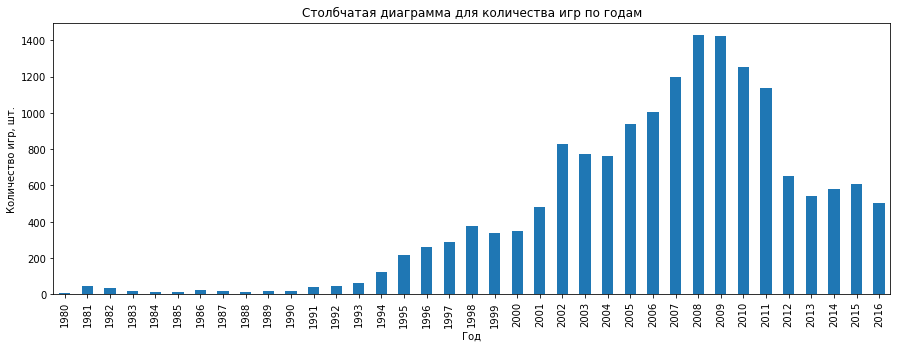

In [32]:
# группируем данные по годам для формирования диаграммы
pivot_of_games.groupby('year_of_release').sum().reset_index().plot.bar(
    x='year_of_release', y='count_games', figsize=(15, 5), legend=False)

plt.title('Столбчатая диаграмма для количества игр по годам')
plt.ylabel('Количество игр, шт.')
plt.xlabel('Год')
plt.show()

Выпуск игр начал набирать обороты с 1994 г., а массовый характер приобрел после 2000 года.

### Анализ продаж в разрезе платформ, распределение их по годам ###

Определим платформы с наибольшим количеством продаж за все время.

In [33]:
# группируем данные по платформам
grouped_of_platform = pivot_of_games.groupby('platform')['sum_general_sales'].sum().sort_values(ascending=False).reset_index()

grouped_of_platform

,platform,sum_general_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.33
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


Большой разрыв между продажами происходит после 314 (миллионов проданных копий). Поэтому для анализа как самые крупные платформы возьмем те, у которых суммарные продажи превысили 720 (миллинов проданных копий). 

Список платформ с наибольшим количеством продаж:

In [34]:
list_of_popular_platform = grouped_of_platform.loc[grouped_of_platform['sum_general_sales'] > 720, 'platform'].tolist()

list_of_popular_platform

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

Построим для каждой платформы распределение продаж по годам:

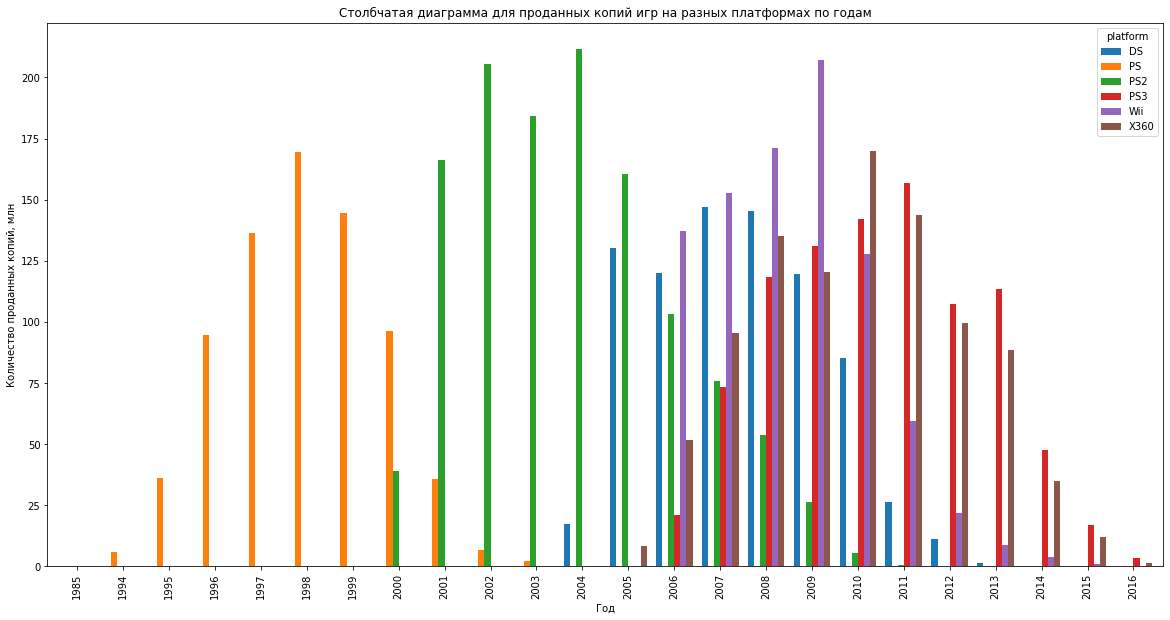

In [35]:
# формируем сводную таблицу с данными только по платформам с наибольшим количеством продаж
games_of_leaders_platform_df = pivot_of_games[pivot_of_games['platform'].isin(list_of_popular_platform)]

# выводим диаграмму продаваемых копий по годам для платформ-лидеров
games_of_leaders_platform_df.pivot_table(
    index='year_of_release', 
    columns='platform', 
    values='sum_general_sales', 
    aggfunc='sum').fillna(0).plot.bar(figsize=(20, 10), width=0.8)

plt.title('Столбчатая диаграмма для проданных копий игр на разных платформах по годам')
plt.ylabel('Количество проданных копий, млн')
plt.xlabel('Год')

plt.show()

Исходя из диаграммы выше, сделаем выводы: 

* цикл жизни популярных платформ - около 10 лет, 
* первые 4-5 лет платформа набирает популярность, достигает пика продаж игр, 
* снижение продаж во второй половине цикла жизни платформы обусловлено появлением более новой платформы у конкуретнов, либо выпуск компанией нового поколения своей платформы. 

### Определение актуального периода для построения прогноза на 2017 год ###

Для прогноза на 2017 год отберем данные с 2012 до 2016 года включительно. 

Выбор обсуловлен тем, что: 

* массовость популярных платформ началась с 2007 года, к 2012 году набран большой объем данных, 
* период охватывает 5 лет - достаточный для прогноза на 1 год, 
* наиболее полный объем данных, по сравнению с предыдущими годами, когда игр выпускалось меньше. 

Подготовим данные для использования при анализе и прогнозировании:

In [36]:
# получаем общий DataFrame с данными за определенный период
filtred_games_df = games_df.loc[games_df['year_of_release'] >= 2012]

filtred_games_df

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,general_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,no rating,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,no rating,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,no rating,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,no rating,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,no rating,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,no rating,0.01


In [37]:
# формируем сводную таблицу с информацией о количестве проданных копий, количестве выпущенных игр 
# по годам, в разрезе платформ и по жанрам
filtred_pivot_of_games = filtred_games_df.pivot_table(
    index=['year_of_release', 'platform', 'genre'],
    values=['name', 'general_sales'],
    aggfunc={'name': ['count'], 'general_sales': ['sum']}
).reset_index()

# корректируем названия столбцов
filtred_pivot_of_games.columns = ['year_of_release', 'platform', 'genre', 'sum_general_sales', 'count_games']

# приводим к типу int столбце с годами
filtred_pivot_of_games['year_of_release'] = filtred_pivot_of_games['year_of_release'].astype(int)

filtred_pivot_of_games

,year_of_release,platform,genre,sum_general_sales,count_games
0,2012,3DS,Action,11.45,40
1,2012,3DS,Adventure,0.97,6
2,2012,3DS,Fighting,0.25,2
3,2012,3DS,Misc,2.35,9
4,2012,3DS,Platform,10.32,4
...,...,...,...,...,...
414,2016,XOne,Role-Playing,1.32,4
415,2016,XOne,Shooter,11.69,15
416,2016,XOne,Simulation,0.13,2
417,2016,XOne,Sports,6.19,11


Сформируем сводные таблицы, где столбцы - это платформы:

In [38]:
# формируем сводную таблицу с медианными значениями, где столбцы - это платформы
pivot_median_where_columns_is_platforms = filtred_games_df.pivot_table(
    index='year_of_release', 
    columns='platform', 
    values='general_sales', 
    aggfunc='median')

pivot_median_where_columns_is_platforms

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,0.19,0.03,0.120,0.310,NaN,0.040,0.190,0.190,0.230,0.435,NaN
2013,0.10,0.15,0.175,0.310,1.530,0.025,0.100,0.185,0.220,0.430,0.800
2014,0.09,NaN,0.100,0.160,0.600,0.010,0.065,0.370,0.130,0.230,0.440
2015,0.09,NaN,0.080,0.050,0.180,0.020,0.030,0.090,0.220,0.180,0.245
2016,0.08,NaN,0.035,0.065,0.085,NaN,0.030,0.180,0.215,0.100,0.060


In [39]:
# формируем сводную таблицу с суммарными значениями, где столбцы - это платформы
pivot_sum_where_columns_is_platforms = filtred_games_df.pivot_table(
    index='year_of_release', 
    columns='platform', 
    values='general_sales', 
    aggfunc='sum')

pivot_median_where_columns_is_platforms

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,0.19,0.03,0.120,0.310,NaN,0.040,0.190,0.190,0.230,0.435,NaN
2013,0.10,0.15,0.175,0.310,1.530,0.025,0.100,0.185,0.220,0.430,0.800
2014,0.09,NaN,0.100,0.160,0.600,0.010,0.065,0.370,0.130,0.230,0.440
2015,0.09,NaN,0.080,0.050,0.180,0.020,0.030,0.090,0.220,0.180,0.245
2016,0.08,NaN,0.035,0.065,0.085,NaN,0.030,0.180,0.215,0.100,0.060


In [40]:
# формируем сводную таблицу с суммарными значениями, где столбцы - это платформы
complete_pivot_sum_where_columns_is_platforms = filtred_games_df.pivot_table(
    index=['year_of_release', 'genre', 'name'], 
    columns='platform', 
    values='general_sales', 
    aggfunc='sum')

complete_pivot_sum_where_columns_is_platforms

platform                                                     3DS  DS    PC  \
year_of_release genre    name                                                
2012            Action   .hack: Sekai no Mukou ni + Versus   NaN NaN   NaN   
                         AKB48+Me                           0.11 NaN   NaN   
                         Abunai: Koi no Sousa Shitsu         NaN NaN   NaN   
                         Ailu de Puzzle                      NaN NaN   NaN   
                         Alan Wake                           NaN NaN  0.07   
...                                                          ...  ..   ...   
2016            Strategy Sid Meier's Civilization VI         NaN NaN  0.24   
                         Stellaris                           NaN NaN  0.04   
                         Total War Attila: Tyrants & Kings   NaN NaN  0.01   
                         Total War: WARHAMMER                NaN NaN  0.13   
                         XCOM 2                              NaN NaN  0.23   

platform                                                     PS3   PS4   PSP  \
year_of_release genre    name                                                  
2012            Action   .hack: Sekai no Mukou ni + Versus  0.03   NaN   NaN   
                         AKB48+Me                            NaN   NaN   NaN   
                         Abunai: Koi no Sousa Shitsu         NaN   NaN  0.01   
                         Ailu de Puzzle                      NaN   NaN  0.04   
                         Alan Wake                           NaN   NaN   NaN   
...                                                          ...   ...   ...   
2016            Strategy Sid Meier's Civilization VI         NaN   NaN   NaN   
                         Stellaris                           NaN   NaN   NaN   
                         Total War Attila: Tyrants & Kings   NaN   NaN   NaN   
                         Total War: WARHAMMER                NaN   NaN   NaN   
                         XCOM 2                              NaN  0.14   NaN   

platform                                                    PSV  Wii  WiiU  \
year_of_release genre    name                                                
2012            Action   .hack: Sekai no Mukou ni + Versus  NaN  NaN   NaN   
                         AKB48+Me                           NaN  NaN   NaN   
                         Abunai: Koi no Sousa Shitsu        NaN  NaN   NaN   
                         Ailu de Puzzle                     NaN  NaN   NaN   
                         Alan Wake                          NaN  NaN   NaN   
...                                                         ...  ...   ...   
2016            Strategy Sid Meier's Civilization VI        NaN  NaN   NaN   
                         Stellaris                          NaN  NaN   NaN   
                         Total War Attila: Tyrants & Kings  NaN  NaN   NaN   
                         Total War: WARHAMMER               NaN  NaN   NaN   
                         XCOM 2                             NaN  NaN   NaN   

platform                                                    X360  XOne  
year_of_release genre    name                                           
2012            Action   .hack: Sekai no Mukou ni + Versus   NaN   NaN  
                         AKB48+Me                            NaN   NaN  
                         Abunai: Koi no Sousa Shitsu         NaN   NaN  
                         Ailu de Puzzle                      NaN   NaN  
                         Alan Wake                           NaN   NaN  
...                                                          ...   ...  
2016            Strategy Sid Meier's Civilization VI         NaN   NaN  
                         Stellaris                           NaN   NaN  
                         Total War Attila: Tyrants & Kings   NaN   NaN  
                         Total War: WARHAMMER                NaN   NaN  
                         XCOM 2                      

Сформируем сводную таблицу с медианными показателями, где столбцы - это жанры:

In [41]:
# формируем сводную таблицу с медианными значениями, где столбцы - это жанры
pivot_median_where_columns_is_genre = filtred_games_df.pivot_table(
    index='year_of_release', 
    columns='genre', 
    values='general_sales', 
    aggfunc='median')

pivot_median_where_columns_is_genre

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
year_of_release,,,,,,,,,,,,
2012,0.170,0.040,0.190,0.190,0.150,0.020,0.245,0.180,0.415,0.195,0.28,0.090
2013,0.200,0.025,0.155,0.175,0.385,0.100,0.340,0.180,0.340,0.105,0.37,0.190
2014,0.205,0.040,0.130,0.160,0.830,0.050,0.170,0.110,0.660,0.120,0.46,0.060
2015,0.070,0.030,0.100,0.190,0.100,0.045,0.150,0.105,0.925,0.200,0.12,0.045
2016,0.050,0.020,0.085,0.040,0.100,0.010,0.050,0.120,0.240,0.025,0.12,0.060


***Основные источники данных для анализа с 2012 по 2016 год получены. Можем приступать к анализу.***

### Анализ динамики продаж в разрезе платформ, определение потенциально прибыльных платформ ###

Проанализируем продажи по годам для каждой платформы с 2012 по 2016 год. 

Построим для каждой платформы распределение продаж по годам:

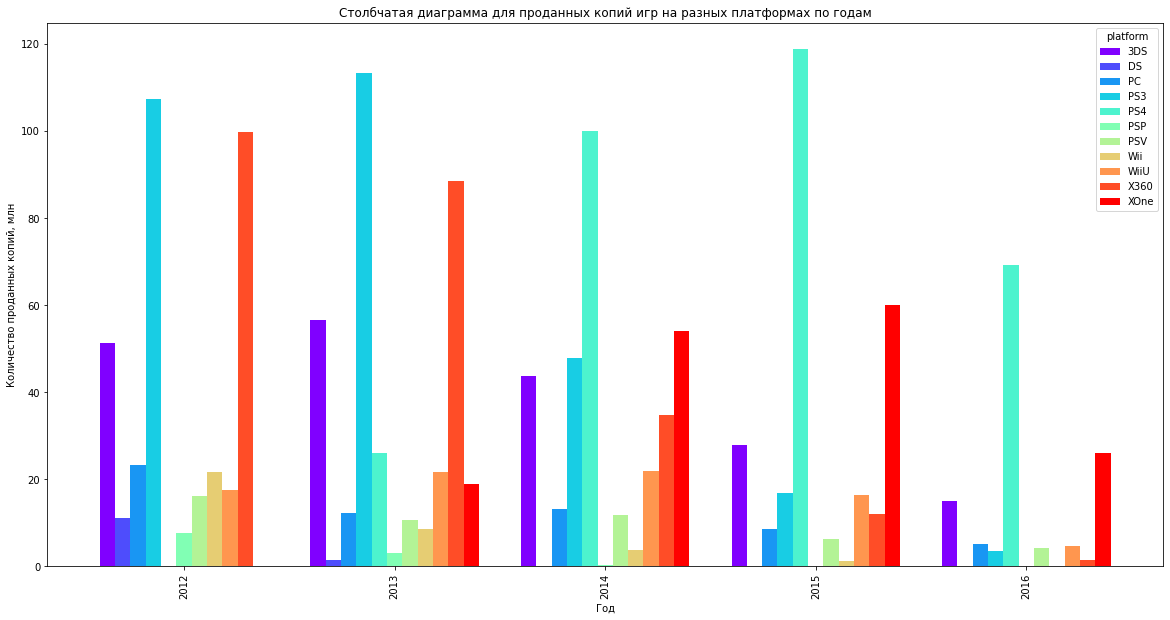

In [42]:
# Генерируем список цветов для каждой платформы
colors = plt.cm.rainbow(np.linspace(0, 1, len(filtred_pivot_of_games['platform'].unique())))

# выводим диаграмму продаваемых копий по годам для платформ
pivot_sum_where_columns_is_platforms.plot.bar(figsize=(20, 10), width=0.8, color=colors)

plt.title('Столбчатая диаграмма для проданных копий игр на разных платформах по годам')
plt.ylabel('Количество проданных копий, млн')
plt.xlabel('Год')

plt.show()

Исходя из диаграммы, можем сделать выводы: 

1. есть компании, платформы которых сменяют друг друга с каждым новым поколением: 
    * DS и 3DS 
    * PS3 и PS4 
    * X360 и XOne. 



2. имеются платформы с низким уровнем продаж за последние 5 лет и без тенденции роста: 
    * DS 
    * PC 
    * PSP 
    * PSV 
    * Wii 
    * WiiU. 



3. лидеры продаж с большими оборотами и потенциальным ростом: 
    * PS4 
    * XOne. 

Построим диаграммы размаха для всех платформ и проализируем основной объем данных без учета выбросов:

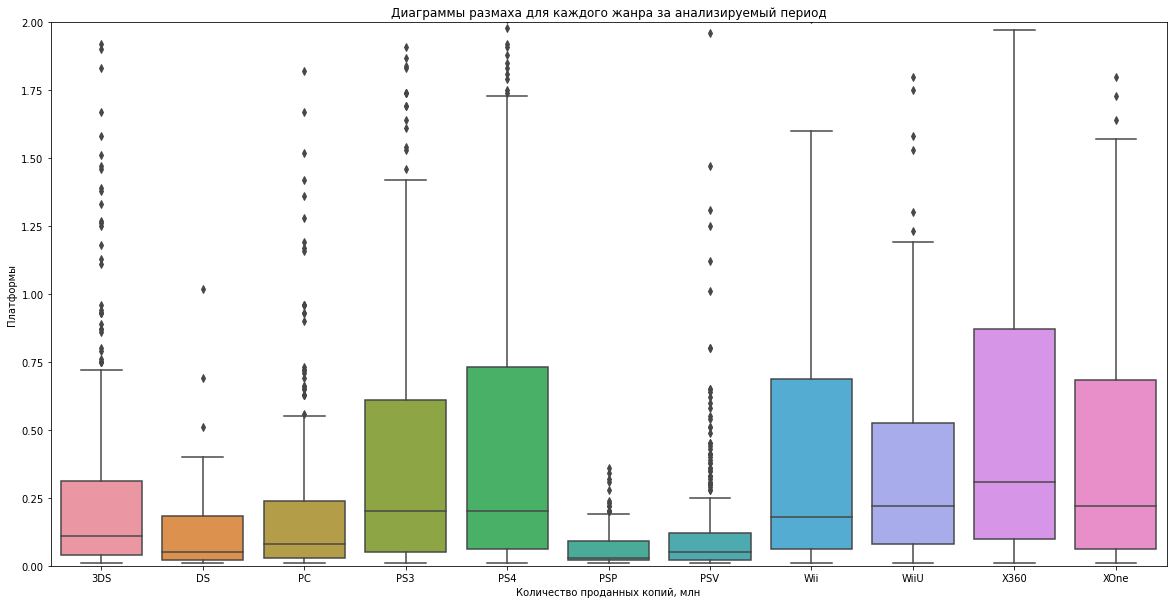

In [43]:
# Генерируем список цветов для каждой платформы
colors = plt.cm.rainbow(np.linspace(0, 1, len(filtred_games_df['platform'].unique())))

plt.figure(figsize=(20, 10))
sns.boxplot(data=complete_pivot_sum_where_columns_is_platforms, orient='vertical')

plt.title("Диаграммы размаха для каждого жанра за анализируемый период")
plt.xlabel("Количество проданных копий, млн")
plt.ylabel("Платформы")
plt.ylim(0, 2)

plt.show()

Диаграммы размаха отражают общую тенденцию успешности игр для каждой платформы. Медиана показывает, какой объем продаж обычно составляет игра на платформе. 

Этот более детальный анализ позволит избежать ошибок при оценке успешности платформы, например, когда несколько игр успешны и занимают 90% от общего объема продаж, в то время как большинство остальных имеют минимальное количество продаваемых копий.

***Выводы:*** 

1. В период с 2012 по 2016 включительно, лидерами по продажам являются: 
    * X360
    * PS4 
    * Wii  
    * XOne 
    * PS3


2. Платформы-лидеры принадлежат 3-м компаниям, платформы которых сменяют друг друга каждое поколение (PS3 и PS4, X360 и XOne, Wii и WiiU).  


3. Платформа последнего поколения из своей серии, набравшая обороты и превысившая популярность своего предыдущего поколения - PS4, остальные консоли последнего поколения пока что не обошли по обороту продаж своих "наследников".

4. Вероятно, лидерами останутся PS4 и XOne, пока не появятся новые платформы от этих же компаний-владельцев. Но продажи XOne в последние годы низкие и имеют тенденцию к снижению. Если компания-владелец не выпустит новую, более популярную платформу, или не продвинет текущую платформу, то рост продаж маловероятен. 

### Оценка влияния отзывов пользователей и критиков на продажи ###

Для анализа рассмотрим показатели нескольких платформ - составим список из 5-ти платформ-лидеров, указанных выше:

In [44]:
list_of_leaders_platforms = [
    'X360',
    'PS4',
    'Wii',
    'XOne',
    'PS3']

list_of_leaders_platforms

['X360', 'PS4', 'Wii', 'XOne', 'PS3']

#### Проанализируем зависимость количества проданных копий от оценки пользователей: ####

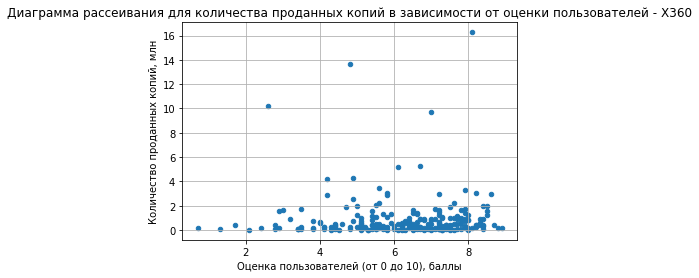

Коэффициент корреляции - X360
0.0061639786462133256


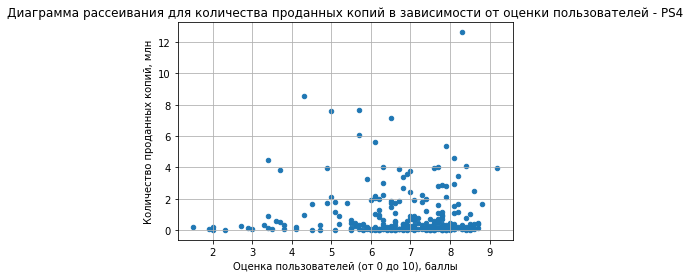

Коэффициент корреляции - PS4
-0.031957110204556376


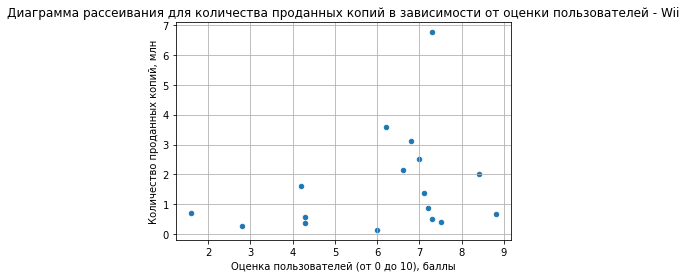

Коэффициент корреляции - Wii
0.2961968000747953


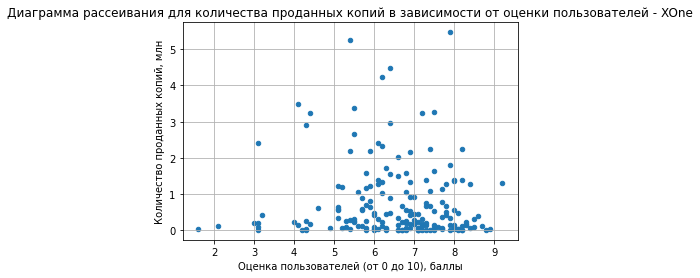

Коэффициент корреляции - XOne
-0.06892505328279412


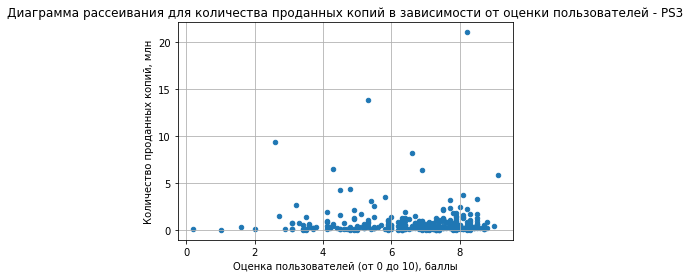

Коэффициент корреляции - PS3
-0.006205767686051522


In [45]:
for platform in list_of_leaders_platforms:
    filtred_games_df.loc[filtred_games_df['platform'] == platform].dropna(subset=['user_score', 'general_sales']).plot(
    x='user_score', y='general_sales', kind='scatter', grid=True)

    plt.title(f'Диаграмма рассеивания для количества проданных копий в зависимости от оценки пользователей - {platform}')
    plt.ylabel('Количество проданных копий, млн')
    plt.xlabel('Оценка пользователей (от 0 до 10), баллы')

    plt.show()
    
    print(f'Коэффициент корреляции - {platform}')
    print(
        filtred_games_df.loc[filtred_games_df['platform'] == platform].dropna(
            subset=['user_score', 'general_sales'])['general_sales'].corr(
            filtred_games_df.dropna(subset=['user_score', 'general_sales'])['user_score']))

Исходя из диаграмм и коэффициентов корреляции - прямая зависимость количества продаж от оценки пользователей минимальна для большинства платформ. 

Исключением является платформа Wii - возможно, из-за того, что она популярна в регионе JP, где пользователи отличаются от регионов NA и EU. 

#### Проанализируем зависимость количества проданных копий от оценки критиков: ####

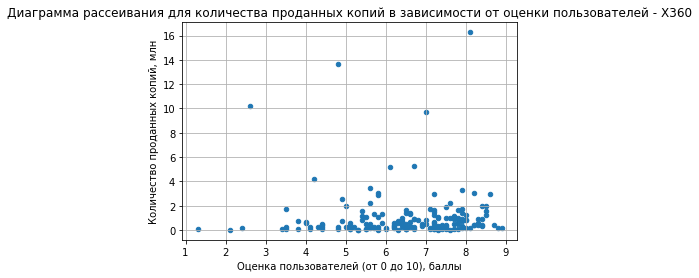

Коэффициент корреляции - X360
0.36057348885073365


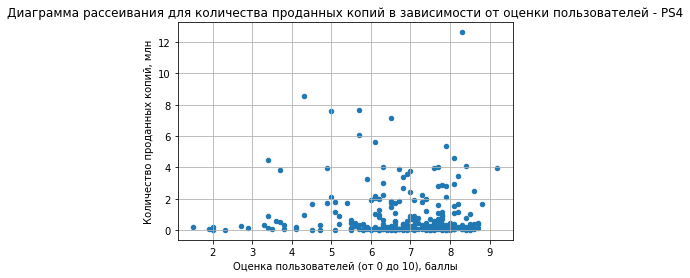

Коэффициент корреляции - PS4
0.406567902061781


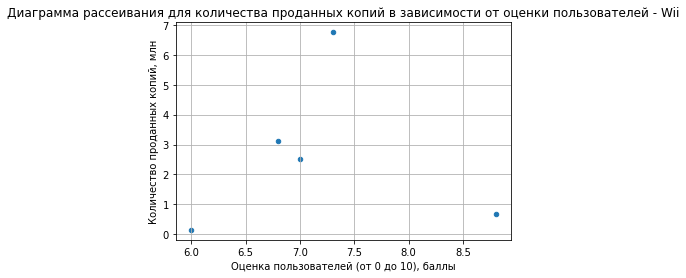

Коэффициент корреляции - Wii
-0.4243413011077495


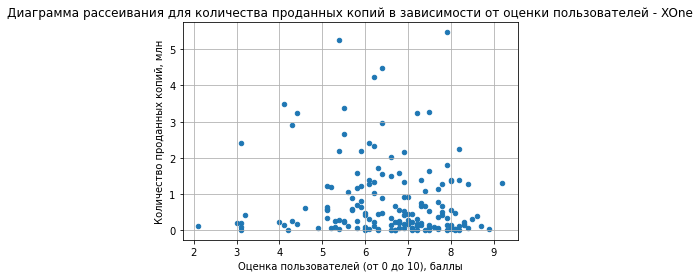

Коэффициент корреляции - XOne
0.41699832800840175


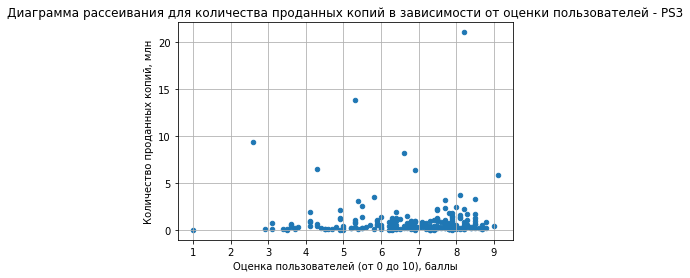

Коэффициент корреляции - PS3
0.3341517575509856


In [46]:
for platform in list_of_leaders_platforms:
    filtred_games_df.loc[filtred_games_df['platform'] == platform].dropna(subset=['critic_score', 'general_sales']).plot(
    x='user_score', y='general_sales', kind='scatter', grid=True)

    plt.title(f'Диаграмма рассеивания для количества проданных копий в зависимости от оценки пользователей - {platform}')
    plt.ylabel('Количество проданных копий, млн')
    plt.xlabel('Оценка пользователей (от 0 до 10), баллы')

    plt.show()
    
    print(f'Коэффициент корреляции - {platform}')
    print(
        filtred_games_df.loc[filtred_games_df['platform'] == platform].dropna(
            subset=['critic_score', 'general_sales'])['general_sales'].corr(
            filtred_games_df.dropna(subset=['critic_score', 'general_sales'])['critic_score']))

Исходя из диаграмм и коэффициентов корреляции - зависимость объема продаж от оценки критиков имеется (чем выше оценка критика, тем больше продаж), но не является основым фактором, влияющим на продажи для большинства платформ. 

Исключением является платформа Wii - но качественно оценить зависимость для данной платформы мы не можем из-за маленького объема данных. 

***Вывод:*** на объем продаж оказывает влияние оценка критиков (чем она выше, тем больше продаж), но это основной фактор. 

Оценки пользователей не оказывают влияния на продажи, кроме платформы Wii (возможно, специфика региона JP, который является основным для данной платформы). 

### Оценка распределения игр по жанрам, анализ прибыльности по жанрам ###

#### Проанализируем распределение количества игр по жанрам с 2012 по 2016 год. ####

Построим круговую диаграмму для оценки долей медианного количества выпущенных игр по жанрам на рынке за весь период с 2012 по 2016:

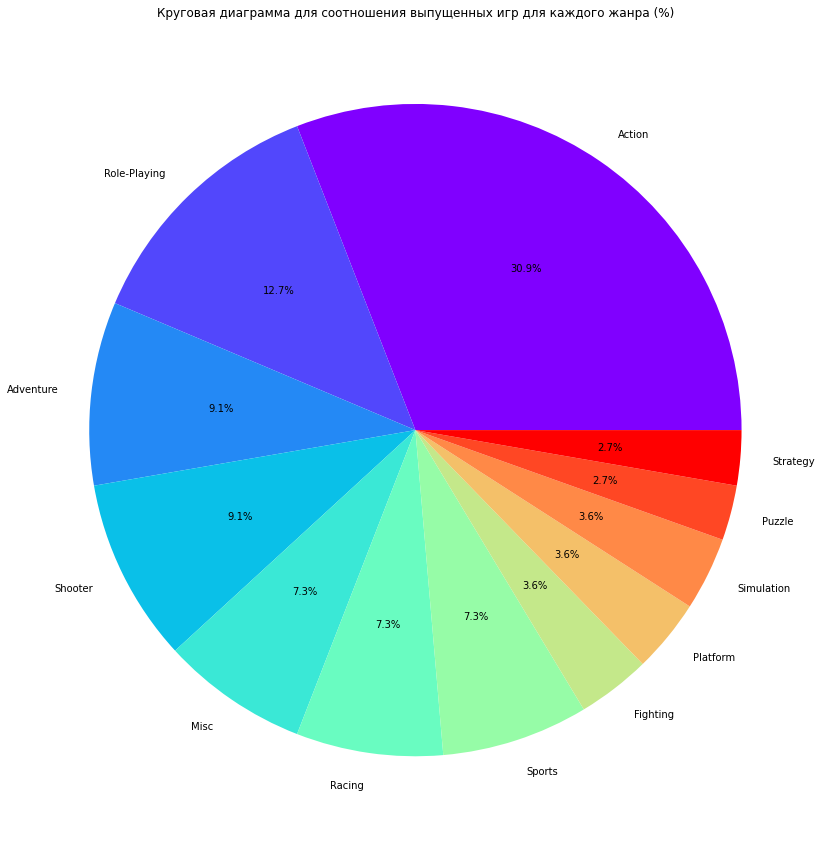

In [47]:
# Генерируем список цветов для каждого жанра
colors = plt.cm.rainbow(np.linspace(0, 1, len(filtred_pivot_of_games['genre'].unique())))

# выводим круговую диаграмму медианного количества выпущенных игр за анализируемый период для каждого жанра
filtred_pivot_of_games.groupby('genre').median()['count_games'].sort_values(ascending=False).plot.pie(
    figsize=(25, 15), autopct='%1.1f%%', colors=colors
)
plt.ylabel('')
plt.title('Круговая диаграмма для соотношения выпущенных игр для каждого жанра (%)')

plt.show()

#### Проанализируем продажи по годам для каждого жанра с 2012 по 2016 год, а также оценим общие продажи за этот период. ####

Построим для каждого жанра распределение медианного количества продаж по годам:

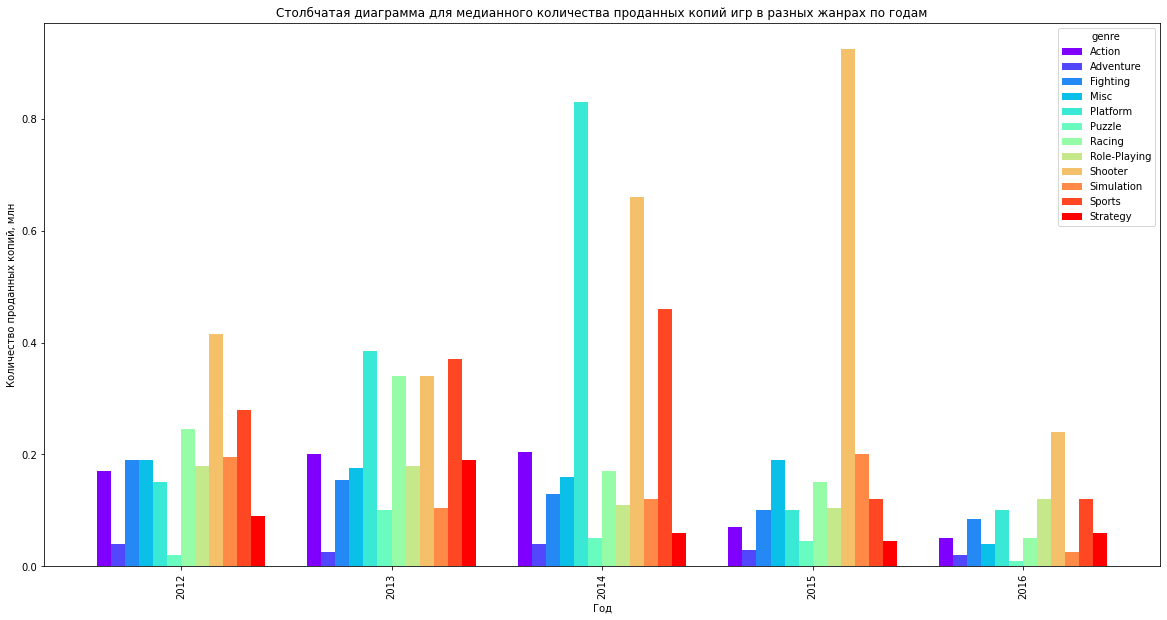

In [48]:
# Генерируем список цветов для каждого жанра
colors = plt.cm.rainbow(np.linspace(0, 1, len(filtred_pivot_of_games['genre'].unique())))

# выводим диаграмму медианного количества продаваемых копий по годам для жанров
pivot_median_where_columns_is_genre.plot.bar(figsize=(20, 10), width=0.8, color=colors)

plt.title('Столбчатая диаграмма для медианного количества проданных копий игр в разных жанрах по годам')
plt.ylabel('Количество проданных копий, млн')
plt.xlabel('Год')

plt.show()

Построим круговую диаграмму для оценки долей продаж по жанрам на рынке за весь период с 2012 по 2016:

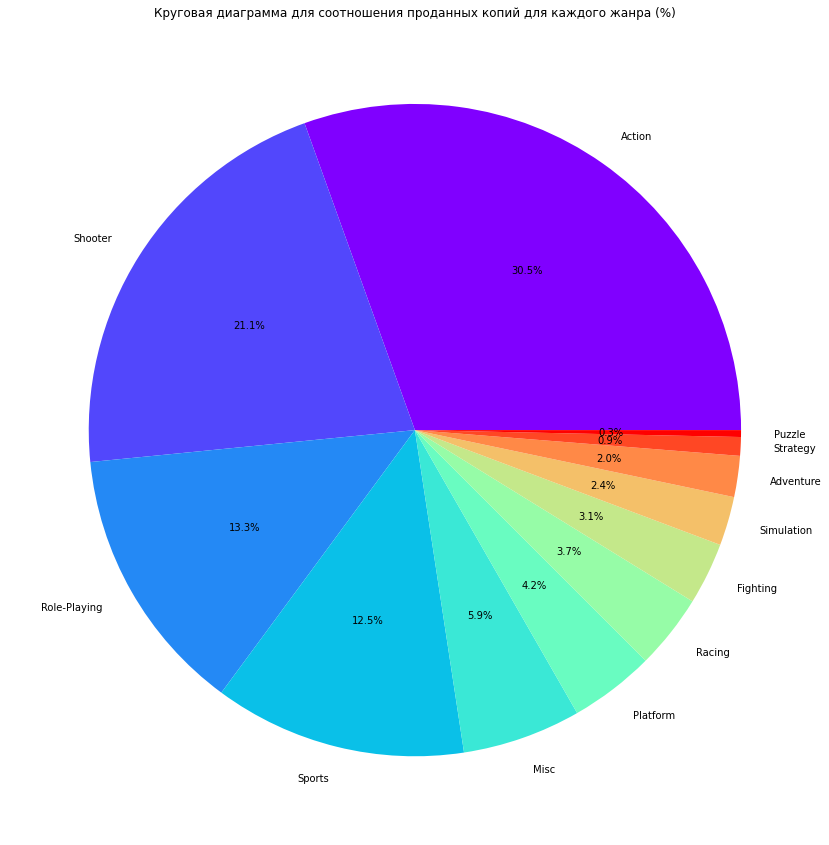

In [49]:
# Генерируем список цветов для каждого жанра
colors = plt.cm.rainbow(np.linspace(0, 1, len(filtred_pivot_of_games['genre'].unique())))

# выводим круговую диаграмму медианного количества продаваемых копий за анализируемый период для каждого жанра
filtred_pivot_of_games.groupby('genre').sum()['sum_general_sales'].sort_values(ascending=False).plot.pie(
    figsize=(25, 15), autopct='%1.1f%%', colors=colors
)
plt.ylabel('')
plt.title('Круговая диаграмма для соотношения проданных копий для каждого жанра (%)')

plt.show()

***Выводы:*** 

* лидером является жанр Shooter, несмотря на то, что в 2013-2014 он уступал место другим жанрам, но ненамного, при этом в остальные годы лидировал с большим отрывом. Также этот игры этого жанра не на первом месте по объему созданных игр, что свидетельствует о качестве игр и спросе на них 
* 2014 год - пик для жанров Platform и Strategy, но в последующих годах популярность снова снизилась до предыдущих показателей 
* доли продаваемых игр по другим жанрам имели небольшое колебание по годам, их продажи более низкие, но стабильно на одном уровне (кроме Shooter, Platform и Strategy) 
* жанр Shooter не входит в тройку лидеров по количеству выпущенных игр, но при этом он находится на втором месте по продажам жанр Shooter
* несмотря на колебания и временный рост продаж по другим жанрам, жанр Shooter оставался и остается лидером продаж при анализе медианных значений - значит, его продажи стабильно высоки. 

**В рамках исследовательского анализа выполнено:** 

1) проанализировано количество игр по годам: 
* выпуск игр начал набирать обороты с 1994 г., а массовый характер приобрел после 2000 года.

2) проанализированы продажи в разрезе платформ и их распределение по годам: 
* цикл жизни популярных платформ - около 10 лет, 
* первые 4-5 лет платформа набирает популярность, достигает пика продаж игр, 
* снижение продаж во второй половине цикла жизни платформы обусловлено появлением более новой платформы у конкуретнов, либо выпуск компанией нового поколения своей платформы. 

3) определен актуальный период для построения прогноза на 2017 год: 
* для прогноза на 2017 год определен период с 2012 до 2016 года включительно, т.к.   
    * массовость популярных платформ началась с 2007 года, к 2012 году набран большой объем данных, 
    * период охватывает 5 лет - достаточный для прогноза на 1 год, 
    * наиболее полный объем данных, по сравнению с предыдущими годами, когда игр выпускалось меньше. 

4) проанализирована динамика продаж в разрезе платформ, определены потенциально прибыльные платформы: 
    
    4.1) в период с 2012 по 2016 включительно, лидерами по продажам являются: 
        * X360
        * PS4 
        * Wii  
        * XOne 
        * PS3


    4.2) платформы-лидеры принадлежат 3-м компаниям, платформы которых сменяют друг друга каждое поколение (PS3 и PS4, X360 и XOne, Wii и WiiU).  


    4.3) платформа последнего поколения из своей серии, набравшая обороты и превысившая популярность своего предыдущего поколения - PS4, остальные консоли последнего поколения пока что не обошли по обороту продаж своих "наследников".

    4.4) вероятно, лидерами останутся PS4 и XOne, пока не появятся новые платформы от этих же компаний-владельцев. Но продажи XOne в последние годы низкие и имеют тенденцию к снижению. Если компания-владелец не выпустит новую, более популярную платформу, или не продвинет текущую платформу, то рост продаж маловероятен. 
    
5) оценено влияние отзывов пользователей и критиков на продажи: 
* на объем продаж оказывает влияние оценка критиков (чем она выше, тем больше продаж), но это основной фактор. 
* оценки пользователей не оказывают влияния на продажи, кроме платформы Wii (возможно, специфика региона JP, который является основным для данной платформы). 
* выводы выше подтверждены как при анализе нескольких популярных платформ (X360, PS4, Wii, XOne, PS3) по данным с 2012 по 2016. 

6) оценено распределение игр по жанрам, проанализирована прибыльность по жанрам: 
* лидером является жанр Shooter, несмотря на то, что в 2013-2014 он уступал место другим жанрам, но ненамного, при этом в остальные годы лидировал с большим отрывом. Также этот игры этого жанра не на первом месте по объему созданных игр, что свидетельствует о качестве игр и спросе на них 
* 2014 год - пик для жанров Platform и Strategy, но в последующих годах популярность снова снизилась до предыдущих показателей 
* доли продаваемых игр по другим жанрам имели небольшое колебание по годам, их продажи более низкие, но стабильно на одном уровне (кроме Shooter, Platform и Strategy) 
* жанр Shooter не входит в тройку лидеров по количеству выпущенных игр, но при этом он находится на втором месте по продажам жанр Shooter
* несмотря на колебания и временный рост продаж по другим жанрам, жанр Shooter оставался и остается лидером продаж при анализе медианных значений - значит, его продажи стабильно высоки. 

## Формирование портрета пользователя для каждого региона (NA, EU, JP) ##

Для анализа сформируем сводную таблицу с данными о количестве проданных копий, количестве выпущенных игр по годам, оценках пользователей и рейтинге ESRB в разрезе платформ и по жанрам.

Для NA (North America):

In [50]:
# формируем сводную таблицу с информацией по регионам
# о количестве проданных копий (общее и по регионам), количестве выпущенных игр, оценках пользователей и рейтинге ESRB 
# по годам, в разрезе платформ и по жанрам
regions_filtred_pivot_of_games = filtred_games_df.pivot_table(
    index=['platform', 'genre'],
    values=['name', 'na_sales', 'eu_sales', 'jp_sales', 'general_sales', 'user_score', 'rating'],
    aggfunc={'name': ['count'],
             'na_sales': ['sum'], 'eu_sales': ['sum'], 'jp_sales': ['sum'], 'general_sales': ['sum'],
             'user_score': ['median'], 'rating': lambda x: pd.Series(x).mode()}
).reset_index()

# корректируем названия столбцов
regions_filtred_pivot_of_games.columns = ['platform', 'genre',
                                          'sum_eu_sales', 'sum_general_sales', 'sum_jp_sales', 'sum_na_sales',
                                          'count_games', 'mode_rating', 'median_user_score']

regions_filtred_pivot_of_games

,platform,genre,sum_eu_sales,sum_general_sales,sum_jp_sales,sum_na_sales,count_games,mode_rating,median_user_score
0,3DS,Action,9.19,45.49,20.51,13.76,156,no rating,7.10
1,3DS,Adventure,0.61,4.30,2.73,0.82,33,no rating,8.00
2,3DS,Fighting,1.47,8.46,2.97,3.51,9,no rating,6.25
3,3DS,Misc,2.08,9.45,5.36,1.70,41,no rating,7.70
4,3DS,Platform,6.26,19.11,4.32,7.28,19,"[E, E10+]",7.15
...,...,...,...,...,...,...,...,...,...
115,XOne,Role-Playing,3.43,10.55,0.01,6.15,14,M,7.20
116,XOne,Shooter,17.80,60.33,0.16,36.86,38,M,6.90
117,XOne,Simulation,0.31,0.69,0.00,0.32,4,no rating,6.30
118,XOne,Sports,8.73,26.74,0.02,15.59,38,E,5.85


### Определение топ-5 популярных платформ ###

#### Топ-5 популярных платформ для региона NA (North America): ####

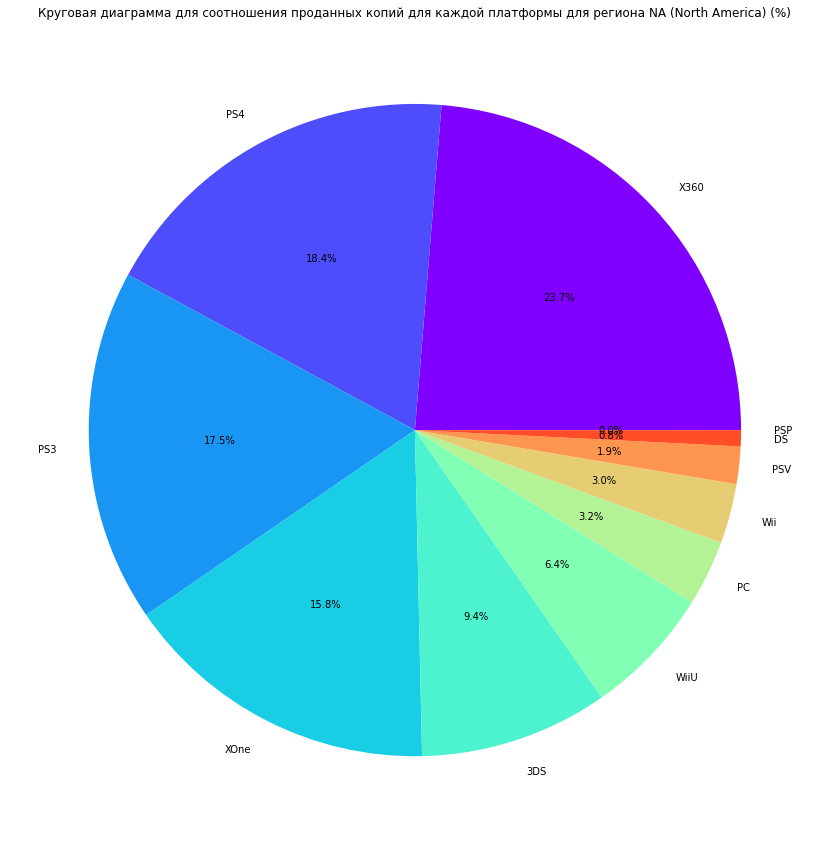

In [51]:
# Генерируем список цветов для каждой платформы
colors = plt.cm.rainbow(np.linspace(0, 1, len(regions_filtred_pivot_of_games['platform'].unique())))

# выводим круговую диаграмму продаваемых копий за анализируемый период для каждой платформы
regions_filtred_pivot_of_games.groupby('platform').sum()['sum_na_sales'].sort_values(ascending=False).plot.pie(
    figsize=(25, 15), autopct='%1.1f%%', colors=colors
)
plt.ylabel('')
plt.title('Круговая диаграмма для соотношения проданных копий для каждой платформы для региона NA (North America) (%)')

plt.show()

In [52]:
print('Топ-5 платформ по количеству проданных копий для региона NA (North America):')

regions_filtred_pivot_of_games.groupby('platform').sum()['sum_na_sales'].sort_values(ascending=False).head(5)

Топ-5 платформ по количеству проданных копий для региона NA (North America):


platform
X360    140.05
PS4     108.74
PS3     103.38
XOne     93.12
3DS      55.31
Name: sum_na_sales, dtype: float64

#### Топ-5 популярных платформ для региона EU (European Union): ####

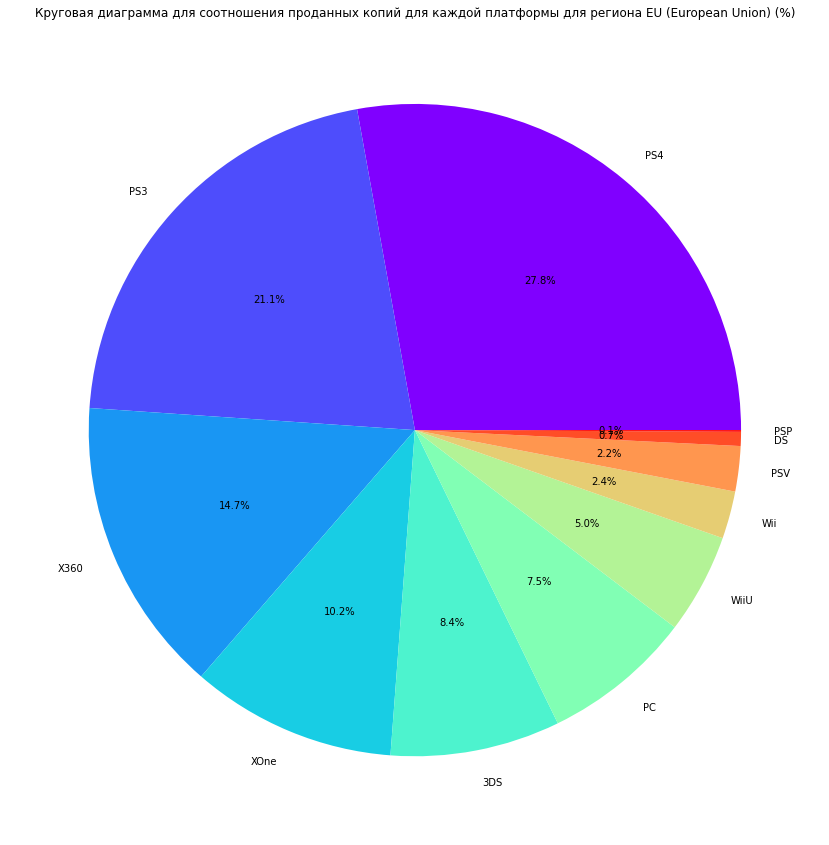

In [53]:
# Генерируем список цветов для каждой платформы
colors = plt.cm.rainbow(np.linspace(0, 1, len(regions_filtred_pivot_of_games['platform'].unique())))

# выводим круговую диаграмму продаваемых копий за анализируемый период для каждой платформы
regions_filtred_pivot_of_games.groupby('platform').sum()['sum_eu_sales'].sort_values(ascending=False).plot.pie(
    figsize=(25, 15), autopct='%1.1f%%', colors=colors
)
plt.ylabel('')
plt.title('Круговая диаграмма для соотношения проданных копий для каждой платформы для региона EU (European Union) (%)')

plt.show()

In [54]:
print('Топ-5 платформ по количеству проданных копий для региона EU (European Union):')

regions_filtred_pivot_of_games.groupby('platform').sum()['sum_eu_sales'].sort_values(ascending=False).head(5)

Топ-5 платформ по количеству проданных копий для региона EU (European Union):


platform
PS4     141.09
PS3     106.85
X360     74.52
XOne     51.59
3DS      42.64
Name: sum_eu_sales, dtype: float64

#### Топ-5 популярных платформ для региона JP (Japan): ####

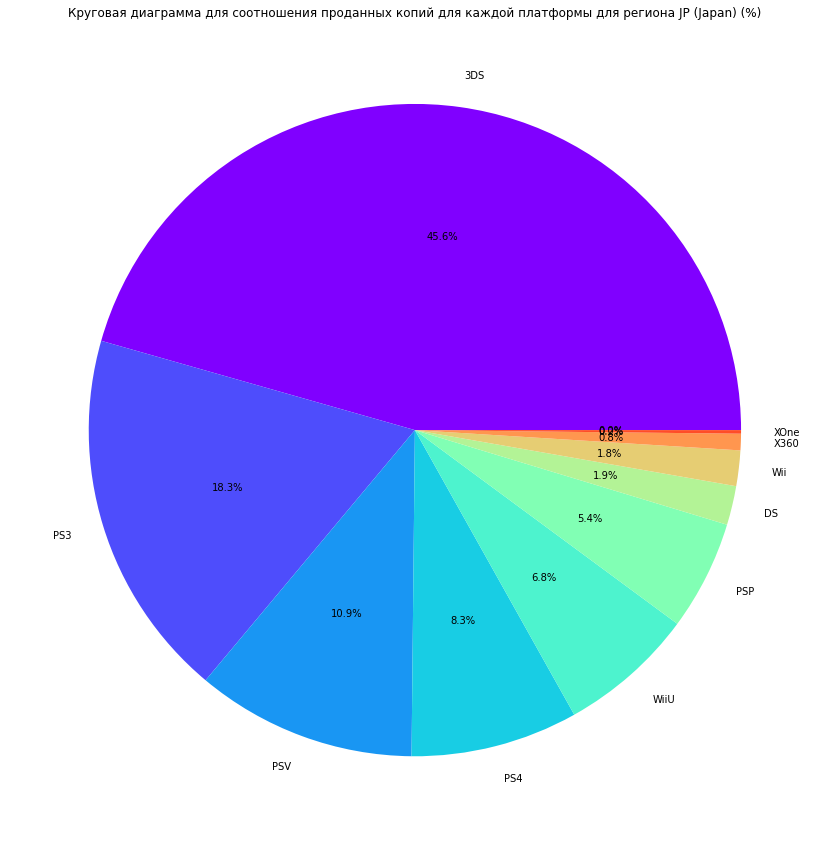

In [55]:
# Генерируем список цветов для каждой платформы
colors = plt.cm.rainbow(np.linspace(0, 1, len(regions_filtred_pivot_of_games['platform'].unique())))

# выводим круговую диаграмму продаваемых копий за анализируемый период для каждой платформы
regions_filtred_pivot_of_games.groupby('platform').sum()['sum_jp_sales'].sort_values(ascending=False).plot.pie(
    figsize=(25, 15), autopct='%1.1f%%', colors=colors
)
plt.ylabel('')
plt.title('Круговая диаграмма для соотношения проданных копий для каждой платформы для региона JP (Japan) (%)')

plt.show()

In [56]:
print('Топ-5 платформ по количеству проданных копий для региона JP (Japan):')

regions_filtred_pivot_of_games.groupby('platform').sum()['sum_jp_sales'].sort_values(ascending=False).head(5)

Топ-5 платформ по количеству проданных копий для региона JP (Japan):


platform
3DS     87.79
PS3     35.29
PSV     21.04
PS4     15.96
WiiU    13.01
Name: sum_jp_sales, dtype: float64

***Вывод (с указанием долей от продаж внутри каждого региона):*** 
* в NA (North America) предпочитают X360 (23.7%) и XOne (15,8%) от одной компании производителя - совокупная доля этих платформ лидирует на рынке, но также популярные PS4 (18.4%), PS3 (17.5%) и 3DS (9.4%) 
* в EU (European Union) предпочитают PS4 (27.8%) и PS3 (21,1%) от одной компании производителя - совокупная доля этих платформ лидирует на рынке, но также популярные X360 (14.7%), XOne (10.2%) и 3DS (8.4%) 
* в JP (Japan) предпочитают 3DS (45.6%) - доля этой платформы лидирует на рынке, но также популярные PS3 (18.3%), PSV (10.9%), PS4 (8.3%) и WiiU (6.8%) 
* в NA и EU одинаковые популярные платформы, отличается только предпочтения между этими платформами (для NA - X360 и XOne, для EU - PS4 и PS3) 
* в JP кардинально отличаются популярные платформы. Среди популярных те, которые не пользуются спросами в других регионах (3DS, PSV, WiiU), но также есть PS3 и PS4, но они не занимают первое место на рынке 
* во всех регионах в топ-5 входят платформы PS3 и PS4. 

### Определение топ-5 популярных жанров ###

#### Топ-5 популярных жанров для региона NA (North America): ####

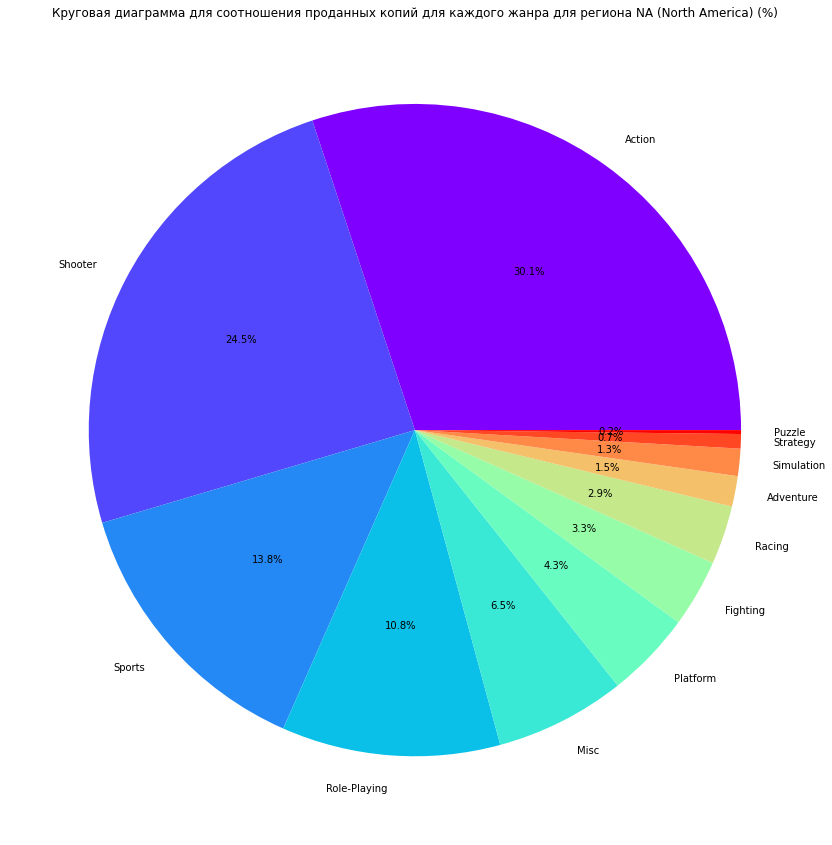

In [57]:
# Генерируем список цветов для каждого жанра
colors = plt.cm.rainbow(np.linspace(0, 1, len(regions_filtred_pivot_of_games['genre'].unique())))

# выводим круговую диаграмму продаваемых копий за анализируемый период для каждого жанра
regions_filtred_pivot_of_games.groupby('genre').sum()['sum_na_sales'].sort_values(ascending=False).plot.pie(
    figsize=(25, 15), autopct='%1.1f%%', colors=colors
)
plt.ylabel('')
plt.title('Круговая диаграмма для соотношения проданных копий для каждого жанра для региона NA (North America) (%)')

plt.show()

In [58]:
print('Топ-5 жанров по количеству проданных копий для региона NA (North America):')

regions_filtred_pivot_of_games.groupby('genre').sum()['sum_na_sales'].sort_values(ascending=False).head(5)

Топ-5 жанров по количеству проданных копий для региона NA (North America):


genre
Action          177.84
Shooter         144.77
Sports           81.53
Role-Playing     64.00
Misc             38.19
Name: sum_na_sales, dtype: float64

#### Топ-5 популярных жанров для региона EU (European Union): ####

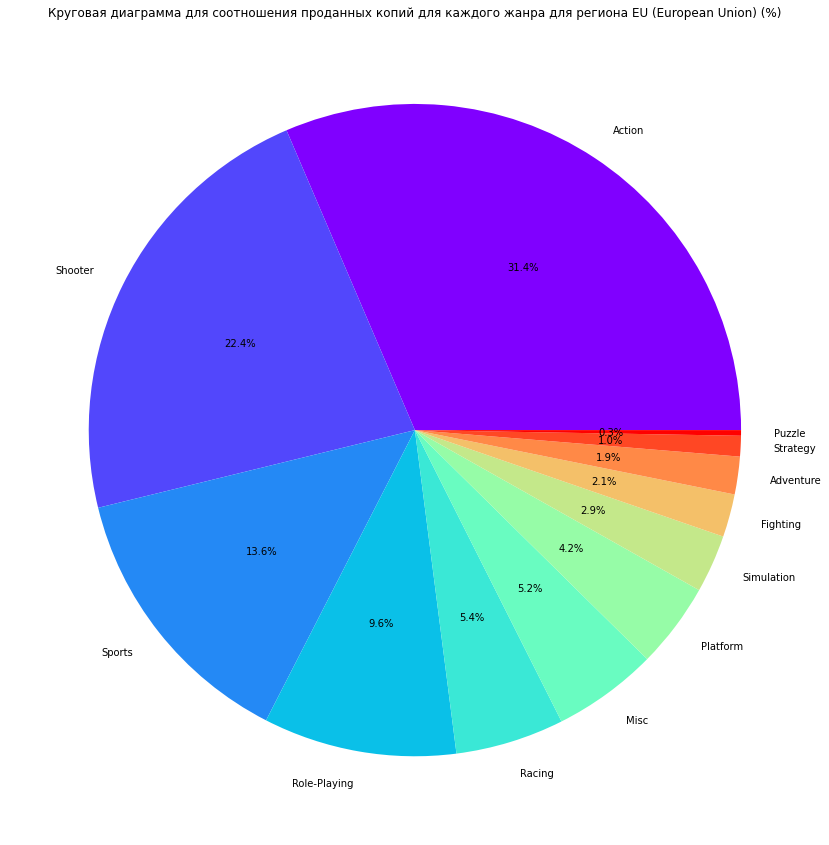

In [59]:
# Генерируем список цветов для каждого жанра
colors = plt.cm.rainbow(np.linspace(0, 1, len(regions_filtred_pivot_of_games['genre'].unique())))

# выводим круговую диаграмму продаваемых копий за анализируемый период для каждого жанра
regions_filtred_pivot_of_games.groupby('genre').sum()['sum_eu_sales'].sort_values(ascending=False).plot.pie(
    figsize=(25, 15), autopct='%1.1f%%', colors=colors
)
plt.ylabel('')
plt.title('Круговая диаграмма для соотношения проданных копий для каждого жанра для региона EU (European Union) (%)')

plt.show()

In [60]:
print('Топ-5 жанров по количеству проданных копий для региона EU (European Union):')

regions_filtred_pivot_of_games.groupby('genre').sum()['sum_eu_sales'].sort_values(ascending=False).head(5)

Топ-5 жанров по количеству проданных копий для региона EU (European Union):


genre
Action          159.34
Shooter         113.47
Sports           69.08
Role-Playing     48.53
Racing           27.29
Name: sum_eu_sales, dtype: float64

#### Топ-5 популярных жанров для региона JP (Japan): ####

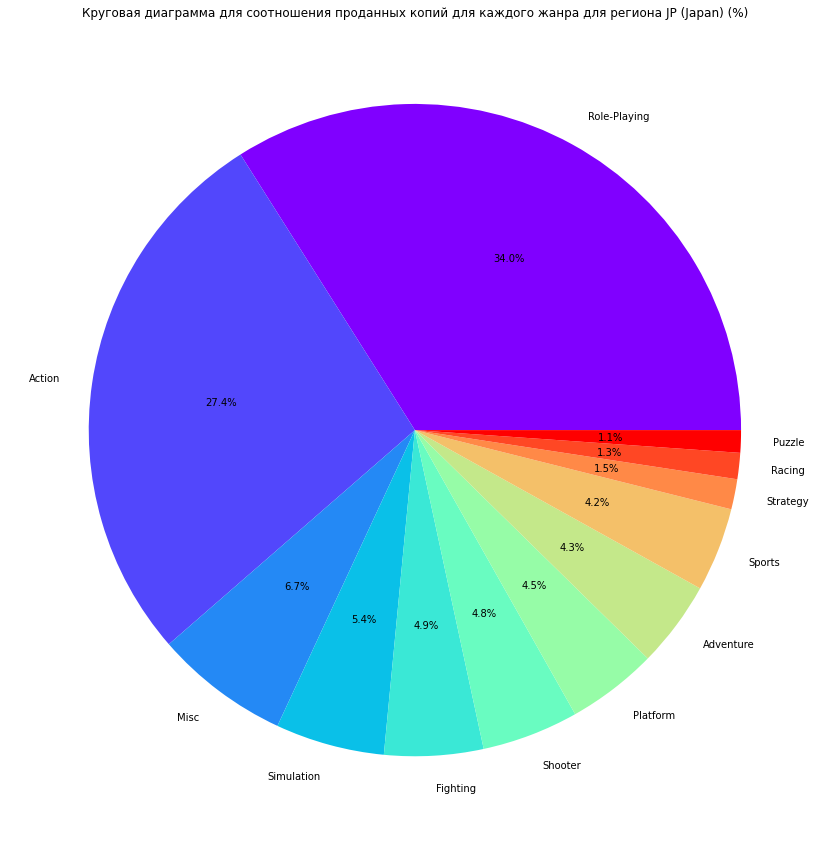

In [61]:
# Генерируем список цветов для каждого жанра
colors = plt.cm.rainbow(np.linspace(0, 1, len(regions_filtred_pivot_of_games['genre'].unique())))

# выводим круговую диаграмму продаваемых копий за анализируемый период для каждого жанра
regions_filtred_pivot_of_games.groupby('genre').sum()['sum_jp_sales'].sort_values(ascending=False).plot.pie(
    figsize=(25, 15), autopct='%1.1f%%', colors=colors
)
plt.ylabel('')
plt.title('Круговая диаграмма для соотношения проданных копий для каждого жанра для региона JP (Japan) (%)')

plt.show()

In [62]:
print('Топ-5 жанров по количеству проданных копий для региона JP (Japan):')

regions_filtred_pivot_of_games.groupby('genre').sum()['sum_jp_sales'].sort_values(ascending=False).head(5)

Топ-5 жанров по количеству проданных копий для региона JP (Japan):


genre
Role-Playing    65.44
Action          52.80
Misc            12.86
Simulation      10.41
Fighting         9.44
Name: sum_jp_sales, dtype: float64

***Вывод (с указанием долей от продаж внутри каждого региона):*** 
* в NA (North America) предпочитают Action (30.1%), Shooter (24.5%), Sports (13.8%), Role-Playing (10.8%) и Misc (6.5%), лидирующие позиции у динамичных активных жанров 
* в EU (European Union) предпочитают Action (31.4%), Shooter (22.4%), Sports (13.6%), Role-Playing (9.6%) и Racing (5.4%), лидирующие позиции у динамичных активных жанров 
* в JP (Japan) предпочитают Role-Playing (34.0%), Action (27.4%), Misc (6.7%), Simulation (5.4%) и Fighting (4.9%), лидирующие позиции у ролевых игр и симуляторов, но также пользуются популярностью динамичные активные жанров 
* в NA и EU совпадают предпочтения жанров, единственное различие - в NA популярен Misc, а в EU популярен Racing, остальные жанры совпадают 
* в JP кардинально отличаются популярные жанры. Среди популярных те, которые не пользуются спросами в других регионах (Role-Playing, Misc, Simulation, Fighting), но также есть жанр Action, входящий в топ-5 во всех регионах 
* во всех регионах в топ-5 входит жанр Action 

### Оценка влияния ESRB на продажи ###

Виды рейтингов: 
* E - для всех любого возраста, 

* EC - для маленьких детей, 

* E10+ - для всех старше 10 лет, 

* T - для подростков от 13 лет и старше, 

* K-A - от детей до взрослых, 

* M - для взрослых с 17 лет, 

* AO - только для взрослых, 

* RP - рейтинг не определен, в процессе оценки. 

#### Оценка влияния ESRB на продажи для региона NA (North America): ####

Построим диаграмму рассеивания для зависимости продаж от рейтинга ESRB:

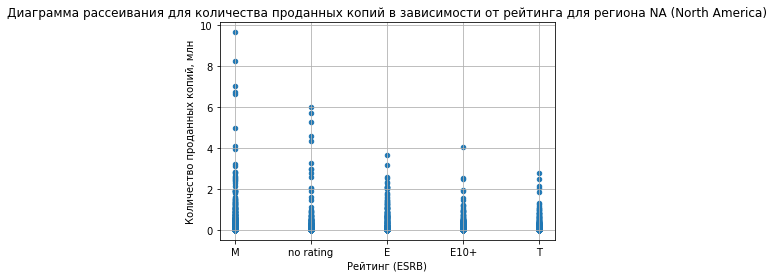

In [63]:
filtred_games_df.plot(
    x='rating', y='na_sales', kind='scatter', grid=True)

plt.title('Диаграмма рассеивания для количества проданных копий в зависимости от рейтинга для региона NA (North America)')
plt.ylabel('Количество проданных копий, млн')
plt.xlabel('Рейтинг (ESRB)')

plt.show()

#### Оценка влияния ESRB на продажи для региона EU (European Union): ####

Построим диаграмму рассеивания для зависимости продаж от рейтинга ESRB:

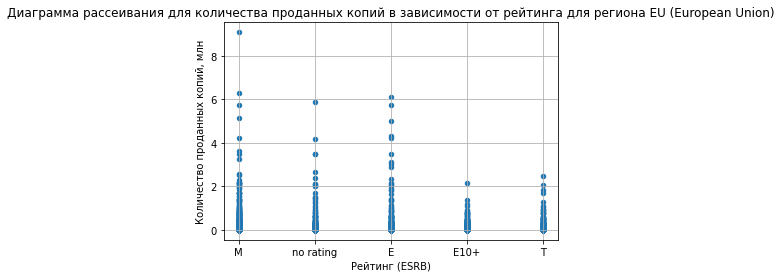

In [64]:
filtred_games_df.plot(
    x='rating', y='eu_sales', kind='scatter', grid=True)

plt.title('Диаграмма рассеивания для количества проданных копий в зависимости от рейтинга для региона EU (European Union)')
plt.ylabel('Количество проданных копий, млн')
plt.xlabel('Рейтинг (ESRB)')

plt.show()

#### Оценка влияния ESRB на продажи для региона JP (Japan): ####

Построим диаграмму рассеивания для зависимости продаж от рейтинга ESRB:

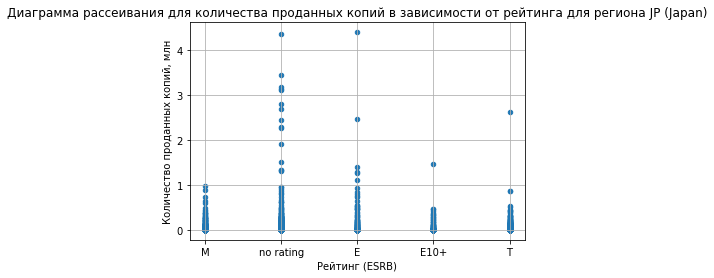

In [65]:
filtred_games_df.plot(
    x='rating', y='jp_sales', kind='scatter', grid=True)

plt.title('Диаграмма рассеивания для количества проданных копий в зависимости от рейтинга для региона JP (Japan)')
plt.ylabel('Количество проданных копий, млн')
plt.xlabel('Рейтинг (ESRB)')

plt.show()

***Выводы:*** 
* для NA (North America) наибольший объем проданных копий с рейтингом "M" (для взрослых с 17 лет), 
* для EU (European Union) наибольший объем проданных копий с рейтингом "E" (для всех любого возраста), но также имеются "выбросы" - часть игр с рейтингом "M" (для взрослых с 17 лет), имеющие рекордное количество продаж, 
* для JP (Japan) наибольший объем проданных копий с рейтингом "E" (для всех любого возраста) и без рейтинга ("no rating") - т.к. рейтинг выставляется преимущественно для игр в США и Канаде, можно сделать вывод о том, что наибольшей популярностью в JP пользуются игры местного производства, либо зарубежные без ограничений по возрасту. 

**В рамках определения топ-5 популярных платформ для каждого региона выполнено:** 

1) определили топ-5 популярных платформ для каждого региона: 
* в NA (North America) предпочитают X360 (23.7%) и XOne (15,8%) от одной компании производителя - совокупная доля этих платформ лидирует на рынке, но также популярные PS4 (18.4%), PS3 (17.5%) и 3DS (9.4%) 
* в EU (European Union) предпочитают PS4 (27.8%) и PS3 (21,1%) от одной компании производителя - совокупная доля этих платформ лидирует на рынке, но также популярные X360 (14.7%), XOne (10.2%) и 3DS (8.4%) 
* в JP (Japan) предпочитают 3DS (45.6%) - доля этой платформы лидирует на рынке, но также популярные PS3 (18.3%), PSV (10.9%), PS4 (8.3%) и WiiU (6.8%) 
* в NA и EU одинаковые популярные платформы, отличается только предпочтения между этими платформами (для NA - X360 и XOne, для EU - PS4 и PS3) 
* в JP кардинально отличаются популярные платформы. Среди популярных те, которые не пользуются спросами в других регионах (3DS, PSV, WiiU), но также есть PS3 и PS4, но они не занимают первое место на рынке 
* во всех регионах в топ-5 входят платформы PS3 и PS4. 

2) определили топ-5 популярных жанров для каждого региона: 
* в NA (North America) предпочитают Action (30.1%), Shooter (24.5%), Sports (13.8%), Role-Playing (10.8%) и Misc (6.5%), лидирующие позиции у динамичных активных жанров 
* в EU (European Union) предпочитают Action (31.4%), Shooter (22.4%), Sports (13.6%), Role-Playing (9.6%) и Racing (5.4%), лидирующие позиции у динамичных активных жанров 
* в JP (Japan) предпочитают Role-Playing (34.0%), Action (27.4%), Misc (6.7%), Simulation (5.4%) и Fighting (4.9%), лидирующие позиции у ролевых игр и симуляторов, но также пользуются популярностью динамичные активные жанров 
* в NA и EU совпадают предпочтения жанров, единственное различие - в NA популярен Misc, а в EU популярен Racing, остальные жанры совпадают 
* в JP кардинально отличаются популярные жанры. Среди популярных те, которые не пользуются спросами в других регионах (Role-Playing, Misc, Simulation, Fighting), но также есть жанр Action, входящий в топ-5 во всех регионах 
* во всех регионах в топ-5 входит жанр Action. 

3) оценили влияние ESRB на продажи: 
* для NA (North America) наибольший объем проданных копий с рейтингом "M" (для взрослых с 17 лет), 
* для EU (European Union) наибольший объем проданных копий с рейтингом "E" (для всех любого возраста), но также имеются "выбросы" - часть игр с рейтингом "M" (для взрослых с 17 лет), имеющие рекордное количество продаж, 
* для JP (Japan) наибольший объем проданных копий с рейтингом "E" (для всех любого возраста) и без рейтинга ("no rating") - т.к. рейтинг выставляется преимущественно для игр в США и Канаде, можно сделать вывод о том, что наибольшей популярностью в JP пользуются игры местного производства, либо зарубежные без ограничений по возрасту. 

## Проверка гипотез ##

### Гипотеза - средние пользовательские рейтинги платформ Xbox One и PC одинаковые ###

Сформулируем нулевую и альтернативную гипотезы: 

H0 (нулевая):
* средний пользовательский рейтинг платформы Xbox One (k0) равен среднему пользовательскому рейтингу платформы PC (k1).
* k0 == k1

H1 (альтернативная двусторонняя): 
* средний пользовательский рейтинг платформы Xbox One (k0) НЕ равен среднему пользовательскому рейтингу платформы PC (k1).
* k0 != k1

Проведем двусторонний t-тест о том, что средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC:

In [66]:
alpha = 0.05 # используем минимальный уровень статистической значимости для более точного теста

results = st.ttest_ind(
    filtred_games_df.dropna(subset=['user_score']).loc[filtred_games_df['platform'] == 'XOne', 'user_score'], 
    filtred_games_df.dropna(subset=['user_score']).loc[filtred_games_df['platform'] == 'PC', 'user_score'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: средние пользовательские рейтинги платформ Xbox One и PC НЕодинаковые')
else:
    print('Не получилось отвергнуть нулевую гипотезу: средние пользовательские рейтинги платформ Xbox One и PC одинаковые')

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу: средние пользовательские рейтинги платформ Xbox One и PC одинаковые


***Вывод:***

Гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, не удалось отвергнуть.

### Гипотеза - средние пользовательские рейтинги жанров Action и Sports разные ###

Сформулируем нулевую и альтернативную гипотезы: 

H0 (нулевая):
* средний пользовательский рейтинг жанра Action (k0) равен среднему пользовательскому рейтингу жанра Sports (k1).
* k0 == k1

H1 (альтернативная двусторонняя): 
* средний пользовательский рейтинг жанра Action (k0) НЕ равен среднему пользовательскому рейтингу жанра Sports (k1).
* k0 != k1

In [67]:
alpha = 0.01 # используем минимальный уровень статистической значимости для более точного теста

results = st.ttest_ind(
    filtred_games_df.dropna(subset=['user_score']).loc[filtred_games_df['genre'] == 'Action', 'user_score'], 
    filtred_games_df.dropna(subset=['user_score']).loc[filtred_games_df['genre'] == 'Sports', 'user_score'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: средние пользовательские рейтинги жанров Action и Sports НЕодинаковые')
else:
    print('Не получилось отвергнуть нулевую гипотезу: средние пользовательские рейтинги жанров Action и Sports одинаковые')

p-значение: 4.8045233804629176e-26
Отвергаем нулевую гипотезу: средние пользовательские рейтинги жанров Action и Sports НЕодинаковые


***Вывод:***

Гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports разные, не удалось отвергнуть.

**В рамках проверки гипотез выполнено:** 

1) проверка гипотезы о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые: 
* гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, не удалось отвергнуть.

2) проверка гипотезы о том, что средние пользовательские рейтинги жанров Action и Sports разные: 
* гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports разные, не удалось отвергнуть.

## Общий вывод ##

**В рамках анализа было выполнено:**

**1. Получение данных из открытых источников о продажах игр, оценках пользователей и экспертов, жанрах и платформах:** 

* первичная информация об играх из csv файла "games" сохранена в DataFrame "games_df" (16715 строк).



**2. Предобработка данных:**

2.1) скорректирован формат наименований столбцов (к стилю snake_case), 

2.2) преобразованы данные в нужные типы: 
* 'user_score' - от object к типу float, т.к. это оценка по десятибальной шкале, 
* 'year_of_release' - от float к типу int, т.к. это год и он не может быть дробным.

2.3) обработаны пропуски: 
* 'year_of_release' - строки удалены, т.к. пропуски невозможно заполнить и количество данных строк минимально, 
* 'genre' - строки удалены из-за минимального набора данных, 
* 'critic_score' - оставлены пропуски, 
* 'user_score' - оставлены пропуски, 
* 'rating' - пропуски заполнены значением-заглушкой "no rating". 

2.4) для каждой строки с игрой рассчитана сумма продаж по всем регионам (создан столбец 'general_sales'). 

2.5) проведена проверка дубликатов: 
* осуществлена проверка неявных дублей в столбце 'platform', 
* найдена и удалена строка с дублирующей информацией.



**3.  Исследовательский анализ:**

3.1) проанализировано количество игр по годам: 
* выпуск игр начал набирать обороты с 1994 г., а массовый характер приобрел после 2000 года.

3.2) проанализированы продажи в разрезе платформ и их распределение по годам: 
* цикл жизни популярных платформ - около 10 лет, 
* первые 4-5 лет платформа набирает популярность, достигает пика продаж игр, 
* снижение продаж во второй половине цикла жизни платформы обусловлено появлением более новой платформы у конкуретнов, либо выпуск компанией нового поколения своей платформы. 

3.3) определен актуальный период для построения прогноза на 2017 год: 
* для прогноза на 2017 год определен период с 2012 до 2016 года включительно, т.к.   
    * массовость популярных платформ началась с 2007 года, к 2012 году набран большой объем данных, 
    * период охватывает 5 лет - достаточный для прогноза на 1 год, 
    * наиболее полный объем данных, по сравнению с предыдущими годами, когда игр выпускалось меньше. 

3.4) проанализирована динамика продаж в разрезе платформ, определены потенциально прибыльные платформы: 
    
    3.4.1) в период с 2012 по 2016 включительно, лидерами по продажам являются: 
        * X360
        * PS4 
        * Wii  
        * XOne 
        * PS3


    3.4.2) платформы-лидеры принадлежат 3-м компаниям, платформы которых сменяют друг друга каждое поколение (PS3 и PS4, X360 и XOne, Wii и WiiU).  


    3.4.3) платформа последнего поколения из своей серии, набравшая обороты и превысившая популярность своего предыдущего поколения - PS4, остальные консоли последнего поколения пока что не обошли по обороту продаж своих "наследников".

    3.4.4) вероятно, лидерами останутся PS4 и XOne, пока не появятся новые платформы от этих же компаний-владельцев. Но продажи XOne в последние годы низкие и имеют тенденцию к снижению. Если компания-владелец не выпустит новую, более популярную платформу, или не продвинет текущую платформу, то рост продаж маловероятен. 
    
3.5) оценено влияние отзывов пользователей и критиков на продажи: 
* на объем продаж оказывает влияние оценка критиков (чем она выше, тем больше продаж), но это основной фактор. 
* оценки пользователей не оказывают влияния на продажи, кроме платформы Wii (возможно, специфика региона JP, который является основным для данной платформы). 
* выводы выше подтверждены как при анализе нескольких популярных платформ (X360, PS4, Wii, XOne, PS3) по данным с 2012 по 2016. 

3.6) оценено распределение игр по жанрам, проанализирована прибыльность по жанрам: 
* лидером является жанр Shooter, несмотря на то, что в 2013-2014 он уступал место другим жанрам, но ненамного, при этом в остальные годы лидировал с большим отрывом. Также этот игры этого жанра не на первом месте по объему созданных игр, что свидетельствует о качестве игр и спросе на них 
* 2014 год - пик для жанров Platform и Strategy, но в последующих годах популярность снова снизилась до предыдущих показателей 
* доли продаваемых игр по другим жанрам имели небольшое колебание по годам, их продажи более низкие, но стабильно на одном уровне (кроме Shooter, Platform и Strategy) 
* жанр Shooter не входит в тройку лидеров по количеству выпущенных игр, но при этом он находится на втором месте по продажам жанр Shooter
* несмотря на колебания и временный рост продаж по другим жанрам, жанр Shooter оставался и остается лидером продаж при анализе медианных значений - значит, его продажи стабильно высоки. 
 


**4. Формирование портрета пользователя для каждого региона:**

4.1) определили топ-5 популярных платформ для каждого региона: 
* в NA (North America) предпочитают X360 (23.7%) и XOne (15,8%) от одной компании производителя - совокупная доля этих платформ лидирует на рынке, но также популярные PS4 (18.4%), PS3 (17.5%) и 3DS (9.4%) 
* в EU (European Union) предпочитают PS4 (27.8%) и PS3 (21,1%) от одной компании производителя - совокупная доля этих платформ лидирует на рынке, но также популярные X360 (14.7%), XOne (10.2%) и 3DS (8.4%) 
* в JP (Japan) предпочитают 3DS (45.6%) - доля этой платформы лидирует на рынке, но также популярные PS3 (18.3%), PSV (10.9%), PS4 (8.3%) и WiiU (6.8%) 
* в NA и EU одинаковые популярные платформы, отличается только предпочтения между этими платформами (для NA - X360 и XOne, для EU - PS4 и PS3) 
* в JP кардинально отличаются популярные платформы. Среди популярных те, которые не пользуются спросами в других регионах (3DS, PSV, WiiU), но также есть PS3 и PS4, но они не занимают первое место на рынке 
* во всех регионах в топ-5 входят платформы PS3 и PS4. 

4.2) определили топ-5 популярных жанров для каждого региона: 
* в NA (North America) предпочитают Action (30.1%), Shooter (24.5%), Sports (13.8%), Role-Playing (10.8%) и Misc (6.5%), лидирующие позиции у динамичных активных жанров 
* в EU (European Union) предпочитают Action (31.4%), Shooter (22.4%), Sports (13.6%), Role-Playing (9.6%) и Racing (5.4%), лидирующие позиции у динамичных активных жанров 
* в JP (Japan) предпочитают Role-Playing (34.0%), Action (27.4%), Misc (6.7%), Simulation (5.4%) и Fighting (4.9%), лидирующие позиции у ролевых игр и симуляторов, но также пользуются популярностью динамичные активные жанров 
* в NA и EU совпадают предпочтения жанров, единственное различие - в NA популярен Misc, а в EU популярен Racing, остальные жанры совпадают 
* в JP кардинально отличаются популярные жанры. Среди популярных те, которые не пользуются спросами в других регионах (Role-Playing, Misc, Simulation, Fighting), но также есть жанр Action, входящий в топ-5 во всех регионах 
* во всех регионах в топ-5 входит жанр Action. 

4.3) оценили влияние ESRB на продажи: 
* для NA (North America) наибольший объем проданных копий с рейтингом "M" (для взрослых с 17 лет), 
* для EU (European Union) наибольший объем проданных копий с рейтингом "E" (для всех любого возраста), но также имеются "выбросы" - часть игр с рейтингом "M" (для взрослых с 17 лет), имеющие рекордное количество продаж, 
* для JP (Japan) наибольший объем проданных копий с рейтингом "E" (для всех любого возраста) и без рейтинга ("no rating") - т.к. рейтинг выставляется преимущественно для игр в США и Канаде, можно сделать вывод о том, что наибольшей популярностью в JP пользуются игры местного производства, либо зарубежные без ограничений по возрасту. 



**5. Проверка гипотез:** 

5.1) проверка гипотезы о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые: 
* гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, не удалось отвергнуть.

5.2) проверка гипотезы о том, что средние пользовательские рейтинги жанров Action и Sports разные: 
* гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports разные, не удалось отвергнуть.


**6. Рекомендации:** 

6.1) Если планируется продажа копий игр в регионе NA (North America): 
* стоит сосредоточиться на продаже игр для платформ X360 и XOne, а также игр для новых поколений платформ от этой же компании, 
* также при выборе игр для продажи, ориентироваться на жанр Shooter, преобладающий на рынке в данном регионе, 
* наилучший выбор игр для продажи, если ориентироваться на рейтинг ESRB - "M" (для взрослых с 17 лет). Но критичным данный критерий не является, в других жанрах игры продаются также в большом объеме.

6.2) Если планируется продажа копий игр в регионе EU (European Union): 
* стоит сосредоточиться на продаже игр для платформ PS3 и PS4, а также игр для новых поколений платформ от этой же компании, 
* также при выборе игр для продажи, ориентироваться на жанр Shooter, преобладающий на рынке в данном регионе, 
* наилучший выбор игр для продажи, если ориентироваться на рейтинг ESRB - "M" (для взрослых с 17 лет). Но критичным данный критерий не является, в других жанрах игры продаются также в большом объеме.

6.3) Если планируется продажа копий игр в регионе JP (Japan): 
* стоит сосредоточиться на продаже игр для платформы 3DS, а также игр для новых поколений платформ от этой же компании, 
* также при выборе игр для продажи, ориентироваться на жанры Role-Playing и Action, преобладающие на рынке в данном регионе, 
* наилучший выбор игр для продажи, если ориентироваться на рейтинг ESRB - "E" (для всех любого возраста) и на игры, производимые в данном регионе, потому не имеющие рейтинга. Но критичным данный критерий не является, в других жанрах игры продаются также в большом объеме.

6.4) Если планируется продажа копий игр сразу во всех регионах: 
* стоит сосредоточиться на продаже игр для платформ PS3 и PS4, а также игр для новых поколений платформ от этой же компании, т.к. эти платформы входят в топ-5 во всех регионах, 
* также при выборе игр для продажи, ориентироваться на жанр Action, т.к. он занимает большую долю рынка в каждом регионе, и жанр Shooter, т.к. он имеет стабильно высокие объемы продаж, 
* наилучший выбор игр для продажи, если ориентироваться на рейтинг ESRB - "E" (для всех любого возраста). Игры с данным рейтингом являются универсальными, т.к. не имеют ограничений, а также в каждом регионе игры с данным жанром занимают большую долю рынка. 

При прогнозировании продаж игр в разрезе платформ, жанров и рейтингов, стоит ориентироваться на рекомендации выше.